In [94]:
from data import get_formatted_data

In [2]:
import numpy as np

In [3]:
from replay_trajectory_classification import ClusterlessDecoder
from replay_trajectory_classification.state_transition import estimate_movement_var
from replay_trajectory_classification.misc import NumbaKDE

In [92]:
multiunits, position = get_formatted_data(data_dir)
print(position.shape)
print(multiunits.shape)

FileNotFoundError: [Errno 2] No such file or directory: b'/run/media/trevortknguyen/a8a15e97-b12c-4825-8482-0be8f89aac96/remy_from_eric/remy_35_02_marks.nc'

In [5]:
model_kwargs = {
    'bandwidth': np.array([1.0, 1.0, 1.0, 1.0, 12.5]) # amplitude 1, amplitude 2, amplitude 3, amplitude 4, position
    }

decoder = ClusterlessDecoder(model_kwargs=model_kwargs)

In [6]:
decoder.fit(position, multiunits)

/home/trevortknguyen/repos/dimensionality/replay_trajectory_classification/state_transition.py:10: RuntimeWarning: invalid value encountered in true_divide
  x /= x.sum(axis=1, keepdims=True)


ClusterlessDecoder(infer_track_interior=True,
                   initial_conditions_type='uniform_on_track',
                   model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                   model_kwargs={'bandwidth': array([ 1. ,  1. ,  1. ,  1. , 12.5])},
                   movement_var=0.05,
                   occupancy_kwargs={'bandwidth': array([ 1. ,  1. ,  1. ,  1. , 12.5])},
                   occupancy_model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                   place_bin_size=2.0, position_range=None, replay_speed=40,
                   transition_type='random_walk')

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
%%timeit

time_ind = slice(0, 50000)
time = np.linspace(0, 1, multiunits.shape[0])

In [44]:
results = decoder.predict(multiunits[time_ind], time=time[time_ind])
results

<xarray.Dataset>
Dimensions:            (position: 172, time: 50000)
Coordinates:
  * time               (time) float64 0.0 2.857e-06 5.714e-06 ... 0.1429 0.1429
  * position           (position) float64 0.9966 2.99 4.983 ... 339.8 341.8
Data variables:
    likelihood         (time, position) float64 0.9854 0.9854 ... 0.9953 0.9954
    causal_posterior   (time, position) float64 0.006352 0.006352 ... 1.363e-114
    acausal_posterior  (time, position) float64 7.815e-16 ... 1.363e-114

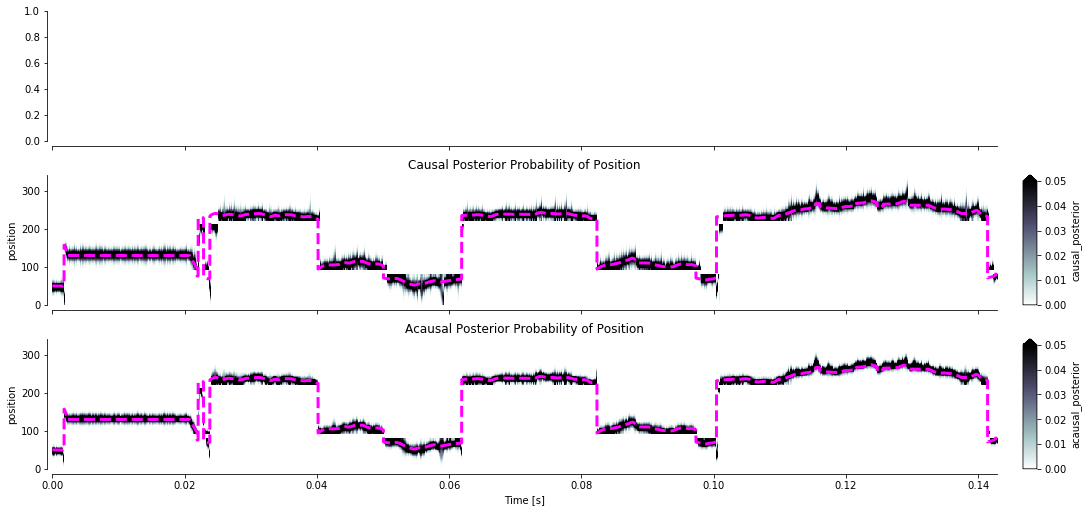

In [46]:
fig, axes = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15, 7))

results.causal_posterior.plot(x="time", y="position", ax=axes[1], cmap="bone_r", vmin=0.0, vmax=0.05, clip_on=False)
axes[1].plot(time[time_ind], position [time_ind], color="magenta", linestyle="--", linewidth=3, clip_on=False)
axes[1].set_xlabel("")
axes[1].set_title("Causal Posterior Probability of Position")
results.acausal_posterior.plot(x="time", y="position", ax=axes[2], cmap="bone_r", vmin=0.0, vmax=0.05, clip_on=False)
axes[2].plot(time[time_ind], position[time_ind], color="magenta", linestyle="--", linewidth=3, clip_on=False)
axes[2].set_title("Acausal Posterior Probability of Position")
axes[2].set_xlabel('Time [s]')
sns.despine(offset=5)

In [58]:
np.max(results.causal_posterior[200])

<xarray.DataArray 'causal_posterior' ()>
array(0.15052322)
Coordinates:
    time     float64 0.0005714

In [74]:
max_values = np.argmax(np.nan_to_num(results.causal_posterior.values), axis=1)

In [86]:
np.mean(np.square(max_values-position[time_ind]))

9661.203172074278

Now we want to get mean square error of the local error.

In [66]:
results.causal_posterior.values.shape

(50000, 172)

In [52]:
import plotly.express as px

In [65]:
px.scatter(x=np.linspace(0,172,172), y=results.causal_posterior.values[200])

In [76]:
px.scatter(x=np.linspace(0,50000,50000), y=max_values)